# Explainable AI Notebook

## Imports

In [1]:
# Set root directory of the project as the current working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    %cd ..


/Users/johannesherstad/Master_Herstad-Gjerdingen


In [2]:
sys.path

['/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python311.zip',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/lib-dynload',
 '',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/setuptools/_vendor']

In [ ]:
# Standard libraries
import random

# Third-party libraries
import mat4py as mpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import os

# Keras Tuner
import kerastuner as kt



# Custom modules 
from src.models import load_preprocessed_data, load_saved_model
from src.evaluation import evaluate_regression_model, plot_true_vs_pred
from config.defaults import Config

config = Config()

## Data loading

In [ ]:
# Load preprocessed data

# Regression
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(task_type = "regression" , eol_capacity=config.eol_capacity)

# Classification
X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, metadata = load_preprocessed_data(task_type = "classification" , eol_capacity=config.eol_capacity)


2025-03-04 12:06:12,259 - INFO - Loaded preprocessed data and metadata for regression with EOL 0.65


## Load and Evaluate models

### Regression

#### LSTM

2025-03-04 11:21:31,847 - INFO - Loaded saved best model from experiments/models/lstm_regression_eol65_20250303_082852_best.keras


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6306e-04 - mae: 0.0200 


2025-03-04 11:21:32,714 - INFO - Test Loss (MSE): 0.0007
2025-03-04 11:21:32,714 - INFO - Test MAE (rescaled): 20.8733


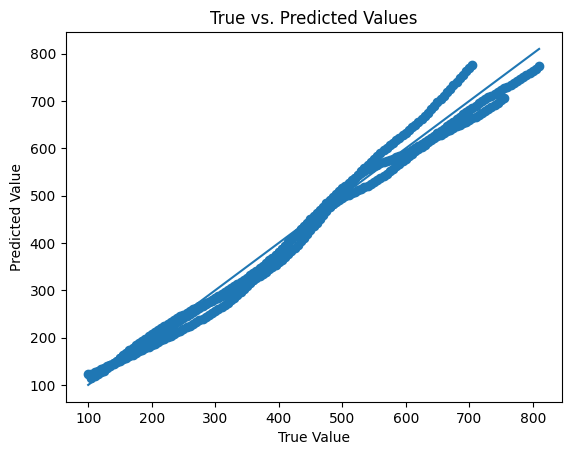

In [11]:
# 1) Load the model
lstm_model = load_saved_model(task_type=task_type, eol_capacity=config.eol_capacity, config=config)

# 2) Generate predictions
y_pred = lstm_model.predict(X_test)

# 3) Evaluate (for example, if your evaluate_regression_model only needs X_test, y_test)
test_loss, mae_rescaled = evaluate_regression_model(
    model=lstm_model, 
    X_test=X_test, 
    y_test=y_test, 
    y_max=metadata["y_max"]
)

# 4) Plot
plot_true_vs_pred(y_test, y_pred, y_max=metadata["y_max"])


#### Interpretable Alternative

### Classification

#### 1D Convolutional Neural Network

#### Decision Tree

#### Logistic regression

## Ante-Hoc Explainability Methods

### SHAP

#### Regression

#### Classification

### TimeSHAP

#### Regression

#### Classification

### Grad-CAM

#### Regression

#### Classification

## Quantitative XAI Evaluation

In this section, we will evaluate the performance of the different XAI methods on the regression and classification tasks.

We will use the following metrics:
* Faithfulness
    * PGI (Prediction-Guided Importance)
    * PGU (Prediction-Guided Unimportance)
*
    


### Faithfulness

Faithfulness is the degree to which the explanation is faithful to the model. It is measured by the correlation between the explanation and the model's prediction.

Through the metrics PGI (Prediction-Guided Importance) and PGU (Prediction-Guided Unimportance), we can measure the faithfulness of the explanation, by perturbing the timesteps deemed most and least important by the XAI methods, and measuring the change in the prediction.

The intuition is that if the XAI method is faithful, perturbing the timesteps deemed most important should have a greater impact on the prediction than perturbing the timesteps deemed least important.

In [6]:
# Identify the most important timesteps from the results of the Explainable AI techniques.
# The result for each technique is a sorted list, containing the indices of the most important timesteps from least to most important.

# LSTM SHAP

# LSTM TimeSHAP

# 1D-CNN SHAP

# 1D-CNN TimeSHAP

# 1D-CNN GradCAM

In [7]:
# Perturbation function

def perturbation_function(x, feature_importance_indices):
    # Recieve a list of indices of either the most or the least important timesteps
    # Perturb the values of these timesteps by adding noise to them
    # Return the perturbed input

    x_perturbed = x.copy()
    for idx in feature_importance_indices:
        noise = np.random.normal(loc=0, scale=0.1)
        x_perturbed[idx] = x_perturbed[idx] + noise
    return x_perturbed


In [8]:
# PGI AND PGU calculation function

def compute_pgi_pgu(model, x, importance_scores, K, runs=10):
    # Compute the PGI and PGU scores for the input x
    # K is the number of timesteps to perturb
    # Runs is the number of times to run the perturbation, to get a more stable estimate
    # Return the PGI and PGU scores

    pgi_scores = []
    pgu_scores = []
    for i in range(runs):
        # Get the indices of the most important timesteps
        feature_importance_indices = importance_scores[:K]

        # Perturb the input for the most important timesteps
        x_perturbed_PGI = perturbation_function(x, feature_importance_indices)

        # Perturb the input for the least important timesteps
        x_perturbed_PGU = perturbation_function(x, feature_importance_indices[::-1])

        # Get the prediction for the original input
        original_prediction = model.predict(x)

        # Get the prediction for the perturbed input for the most important timesteps
        prediction_PGI = model.predict(x_perturbed_PGI)

        # Get the prediction for the perturbed input for the least important timesteps
        prediction_PGU = model.predict(x_perturbed_PGU)

        # Compute the PGI and PGU scores
        pgi = np.linalg.norm(original_prediction - prediction_PGI)
        pgu = np.linalg.norm(original_prediction - prediction_PGU)

        pgi_scores.append(pgi)
        pgu_scores.append(pgu)

    return np.mean(pgi_scores), np.mean(pgu_scores)
